In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
from chinese_calendar import is_workday, is_holiday
import chinese_calendar as calendar
import time, datetime
from  tqdm import tqdm
import numba
from numba import jit
warnings.filterwarnings('ignore')
text = pd.read_csv("PRSA_data.csv",encoding='unicode_escape').convert_dtypes()
text.isnull().sum()


No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [3]:
#preprocess:

#1.feature genertating
#
# text['time'] = text.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
# text = text.set_index('time')


#北风强度值
def transform_north(x):
    if(x.cbwd=='NE' or x.cbwd=='NW'):
        return x.Iws
    else: return 0

text['N_E'] = text.apply(lambda x: transform_north(x),axis=1 )


def transform_four_period(x):
    if(0<=x and x<=6): return 'night'
    elif(x<=12): return 'morning'
    elif(x<=18): return 'afternoon'
    else :return 'evening'
text['period'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )

#spring, summer, fall, winter

def transform_four_season(x):
    if(3<=x and x<=5): return 'spring'
    elif(x<=8): return 'summer'
    elif(x<=10): return 'fall'
    else :return 'winter'
text['season'] = text.apply(lambda x: transform_four_season(x.month),axis=1 )

#the week (weekdays, weekends, or holidays)
def transform_four_Week(year,month,day):
    now_date = datetime.date(year, month, day)
    on_holiday, holiday_name = calendar.get_holiday_detail(now_date)
    if(on_holiday): return 'weekends' if holiday_name is None else 'holiday'
    elif(is_workday(now_date)):return 'workday'
    else: return 'weekends'
text['Week'] = text.apply(lambda x: transform_four_Week(x.year,x.month,x.day),axis=1 )



def norm_to_float(c):
    element = text[c].unique()
    dictionary = dict(zip(element,range(0,len(element)))) #反转
    text[c] = text.apply(lambda x:dictionary[x[c]],axis=1)
    return dictionary
dict_period = norm_to_float('period')
dict_season = norm_to_float('season')
dict_Week = norm_to_float('Week')
# dict_PM2_5 = norm_to_float('pm2.5')





def transform_four_segment(x):
    if(8<=x and x<=9): return 'Morning_rush '
    elif(x<=17): return 'Work'
    elif(x<=19): return 'Evening_rush'
    else :return 'Home'
text['segment'] = text.apply(lambda x: transform_four_period(x.hour),axis=1 )
dict_Segment = norm_to_float('segment')


text['diff'] = text['DEWP']-text['N_E']

from sklearn.decomposition import PCA
pca  = PCA(n_components=1)
text['composition'] = pca.fit_transform(list(zip(text['DEWP'],-text['N_E'])))



text['cbwd'].unique()
text = text.join(pd.get_dummies(text['cbwd']).astype('float'))
del text['cbwd']

#2.processing the missing value
#from the segment3 ,this is the best choice :fill with mean
#We using the text to fillin to simplify ; The right way is to fill in with Train_set
text=text.fillna(int(text['pm2.5'].mean()))

In [4]:
def transform_three_kinds(x):
    if(x<=35) :return 'low'
    elif(x<=150): return 'polluting '
    else:return 'very high'
text['pm2.5'] =text.apply(lambda x: transform_three_kinds(x['pm2.5']),axis=1)
dict_PM2_5 = norm_to_float('pm2.5')

In [5]:
#区分训练集和测试集:
def generate_dataset(data):
    #先划分数据集
    Train_set=pd.DataFrame(columns=text.columns)
    Test_set=pd.DataFrame(columns=text.columns)
    text_data =data.groupby(['year','month','day'])
    for index,(name,data)  in enumerate(text_data):
        if((index+1)%7 ==0):
            Test_set =Test_set.append(data)
        else:
            Train_set = Train_set.append(data)

    return Train_set,Test_set
Train_set,Test_set = generate_dataset(text)

In [108]:
sub_train_test =Train_set.loc[:,['DEWP','TEMP','PRES','Iws','Is','Ir']]

In [109]:
rolling_array = sub_train_test.rolling(3).mean()

In [110]:
new_Train_set = Train_set.copy()

for i in ['DEWP','TEMP','PRES','Iws','Is','Ir']:
    new_Train_set[i] = rolling_array[i]


In [111]:
new_Train_set.dropna(inplace=True)


In [112]:
new_Train_set


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv,period,season,Week
2,3,2010,1,1,2,98,-21.000000,-11.333333,1020.000000,4.473333,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
3,4,2010,1,1,3,98,-21.000000,-12.333333,1019.333333,7.156667,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
4,5,2010,1,1,4,98,-20.666667,-12.333333,1018.666667,9.840000,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
5,6,2010,1,1,5,98,-20.000000,-12.000000,1018.000000,12.970000,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
6,7,2010,1,1,6,98,-19.333333,-10.333333,1017.333333,16.100000,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8,-22.333333,-1.666667,1033.333333,226.456667,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1
43820,43821,2014,12,31,20,10,-22.333333,-2.333333,1033.666667,231.970000,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1
43821,43822,2014,12,31,21,10,-22.333333,-2.666667,1034.000000,237.483333,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1
43822,43823,2014,12,31,22,8,-22.000000,-3.333333,1034.000000,242.400000,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1


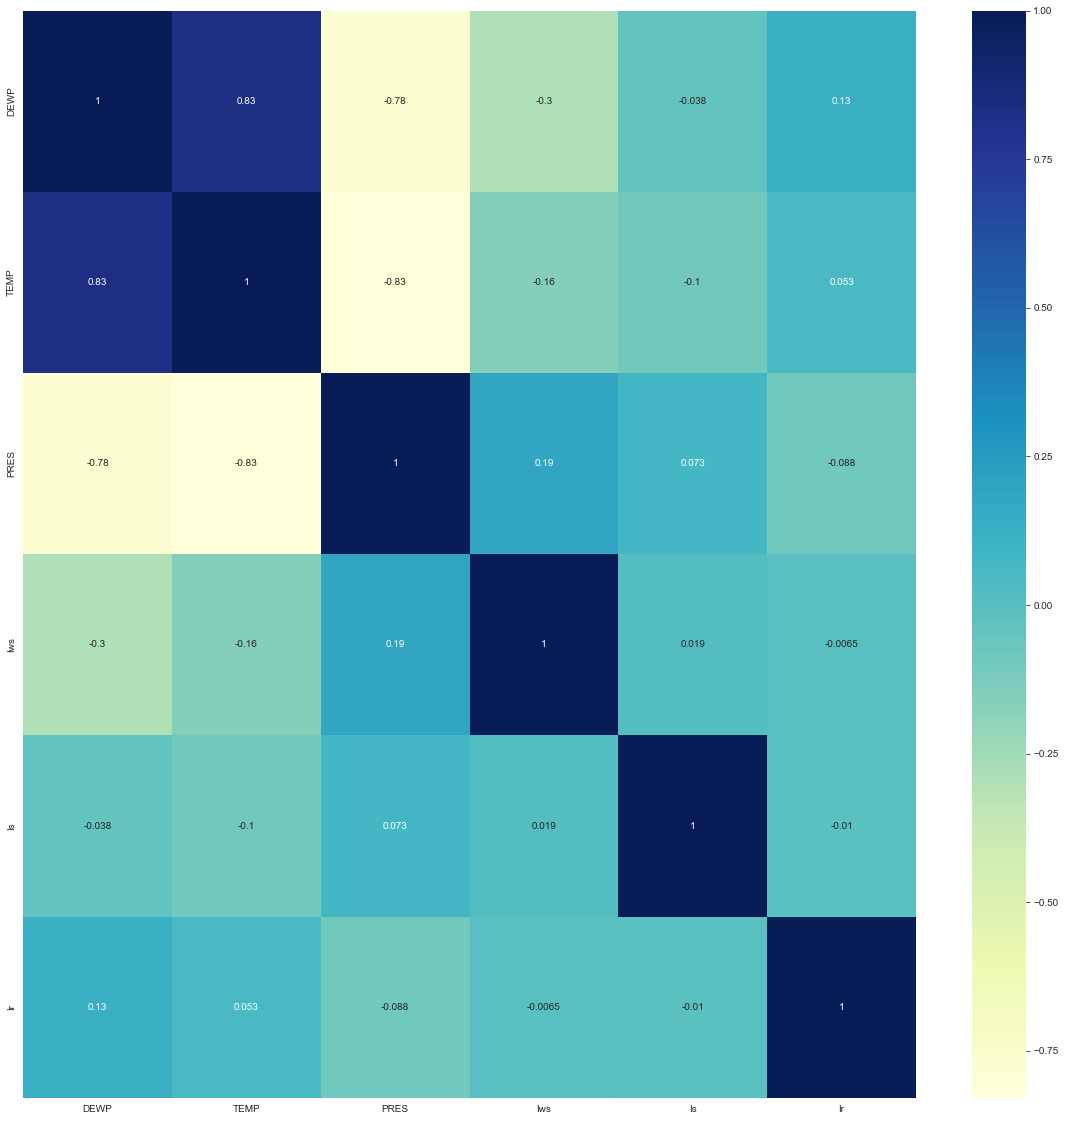

In [113]:
import seaborn as sns
ax = sns.heatmap(new_Train_set.corr(), annot=True, cmap="YlGnBu")
ax.figure.set_size_inches(20,20)

In [12]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.utils import shuffle

#shuffle True: 打乱顺序  select = "Regression" or other
def get_score(trainset,testset,select,shuffle=False):

    if(shuffle==True):
        trainset = shuffle(trainset)
        testset = shuffle(testset)
    x_train =trainset.astype("float")
    x_test =testset.astype("float")

    y_train =x_train.pop('pm2.5')
    y_test =x_test.pop('pm2.5')
    if(select=='Regression'):
        model = XGBRegressor( objective='reg:linear',
                              colsample_bytree=0.3,
                              learning_rate=0.1,
                              max_depth=5,
                              n_estimators=5000,
                              alpha=10)
    else:
        model = XGBClassifier( objective='reg:linear',
                               colsample_bytree=0.3,
                               learning_rate=0.1,
                               max_depth=5,
                               n_estimators=5000,
                               alpha=10)
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    score = model.score(x_test,y_test)
    return score,predict,y_test

In [13]:
scores,prediction,_ = get_score(Train_set
                                ,Test_set,'_')


In [14]:
scores

0.7525641025641026

In [ ]:

#滑动窗口+回归预测问题:

